In [17]:
import pathlib
import datetime
import json
from collections import defaultdict
import pathlib
import os

from readability import Readability
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import ollama
import numpy as np
from pydantic import BaseModel
from dotenv import load_dotenv
from openai import OpenAI

load_dotenv()

CWD = pathlib.Path("").parent

openai_client = OpenAI(
    api_key=os.getenv("OPENAI_API_KEY"),
)

try:
    _ = Readability('')
except:
    import nltk
    nltk.download('punkt_tab')

In [18]:
# Load the dataset
dfs = pd.read_excel('./data/accumulative_metrics.xlsx', sheet_name=None)

In [19]:
# Preprocessing
assignment_names = ['Suffrage', 'Ants', 'Clouds', 'Waterclocks', 'Lizards', 'Tastes', 'Lodgepoles']
num_of_questions = [18, 5, 5, 5, 5, 5, 5]
all_dfs = []

# Keep only the top features
with open('handpicked_top_features.json', 'r') as f:
    top_features = json.load(f)['features']

print([x for x in top_features])

for i, assignment_name in enumerate(assignment_names):
    df = dfs[assignment_name]
    assignment_top_features = [f"{assignment_name}_{x}" for x in top_features]
    df = df[['id', f"{assignment_name}_score"] + assignment_top_features + [f"{assignment_name}_{j+1}" for j in range(num_of_questions[i])]]
    df['assignment'] = assignment_name

    # Remove assignment prefix
    df.columns = df.columns.str.replace(f"{assignment_name}_", '')

    # Drop nan
    df = df.dropna()

    # Set the 'id' as index
    all_dfs.append(df)

# Add student attributes and join via 'id
student_attributes = pd.read_excel('./data/student_attributes.xlsx')
all_dfs = [df.merge(student_attributes, on='id', how='left') for df in all_dfs]

# Drop disability data ('disability', and 'disability_type') and convert "Yes" and "No" in "ELL" to 1 and 0
for i in range(len(all_dfs)):
    df = all_dfs[i]
    df = df.drop(['disability', 'disability_type', 'home_language'], axis=1)
    df['ELL'] = df['ELL'].apply(lambda x: 1 if x == 'Yes' else 0)
    
    # Make the 'id' the index
    # df = df.set_index('id')

    # Store
    all_dfs[i] = df


# Show 'Suffrage' df
print(all_dfs[0].head())

['coldread_gaze_wpm_median', 'coldread_gaze_wpm_std', 'coldread_coverage_line_%', 'coldread_dwell_time_pdf', 'qa_fix_dispersion_mean', 'qa_dwell_time_quiz', 'qa_dwell_time_pdf']
    id     score  coldread_gaze_wpm_median  coldread_gaze_wpm_std  \
0  103  0.666667                    205.89                 131.40   
1  104  0.444444                    167.56                 123.73   
2  105  0.444444                     78.28                  67.78   
3  108  0.444444                    128.67                 164.90   
4  109  0.388889                    137.26                  56.45   

   coldread_coverage_line_%  coldread_dwell_time_pdf  qa_fix_dispersion_mean  \
0                     68.42                   135.08                    1.93   
1                     75.79                   183.95                    1.94   
2                     41.05                    95.58                    0.00   
3                     43.16                    83.68                    2.78   
4      

/tmp/ipykernel_483482/1425155231.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['assignment'] = assignment_name
/tmp/ipykernel_483482/1425155231.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['assignment'] = assignment_name
/tmp/ipykernel_483482/1425155231.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stabl

In [20]:
# For each assignment, perform the same processing
score_distribution_dir = CWD / 'data' / 'output' / 'score_distribution'
os.makedirs(score_distribution_dir, exist_ok=True)
for assignment_name, df in zip(assignment_names, all_dfs):

    # Generate groups based on the mean and std thresholds and plot the distribution of the group scores
    mean = df['score'].mean()
    std = df['score'].std()
    high_threshold = mean + std/1.5
    low_threshold = mean - std/1.5

    # Create a new figure for each assignment
    plt.figure()

    # Plot the distribution of the scores
    sns.histplot(df['score'], kde=True)

    # Add the mean and median
    plt.axvline(mean, color='r', linestyle='dashed', linewidth=1, label='Classroom Mean')

    # Add the thresholds
    plt.axvline(high_threshold, color='g', linestyle='dashed', linewidth=1)
    plt.axvline(low_threshold, color='g', linestyle='dashed', linewidth=1)

    # Plot the mean score for special groups (Disability and ELL)
    ell_mean = df[df['ELL'] == 'Yes']['score'].mean()
    plt.axvline(ell_mean, color='b', linestyle='dashed', linewidth=1, label='ELL Mean')

    # Add legend with the values
    plt.legend({
        f"KDE": None,
        f'Classroom Mean={mean:.2f}': mean,
        f'High Threshold={high_threshold:.2f}': high_threshold,
        f'Low Threshold={low_threshold:.2f}': low_threshold,
        f'ELL Mean={ell_mean:.2f}': ell_mean
    })
    plt.title(f'{assignment_name} - Distribution of Scores')

    # Show the plot
    # plt.show()
    # Save the plot

    plt.savefig(str(score_distribution_dir / f'{assignment_name}.png'))
    plt.close()

In [21]:
for assignment_name, df in zip(assignment_names, all_dfs):
    df['group'] = ''
    df.loc[df['score'] > high_threshold, 'group'] = 'H' # High Performers
    df.loc[(df['score'] <= high_threshold) & (df['score'] > low_threshold), 'group'] = 'M' # Medium Performers
    df.loc[(df['score'] <= low_threshold), 'group'] = 'L' # Low Performers
    df.head(10)

In [22]:
# for assignment_name, df in zip(assignment_names, all_dfs):

#     # Compute the mean and std of each feature by group
#     numeric_df = df.select_dtypes(include='number')
#     all_grouped = numeric_df.groupby(df['group']).mean()
#     num_of_rows = len(top_features) // 3 + 1

#     # Make into subplots and plot each feature separately
#     fig, axs = plt.subplots(num_of_rows, 3, figsize=(20, 10))
#     fig.suptitle(f'{assignment_name} - Feature Distribution by Group')
#     for i, feature in enumerate(top_features):
#         feature_df = all_grouped[[f"{assignment_name}_{feature}"]]
#         feature_df.loc[['H', 'M', 'L']].T.plot(kind='bar', ax=axs[i//3, i%3], title=feature)

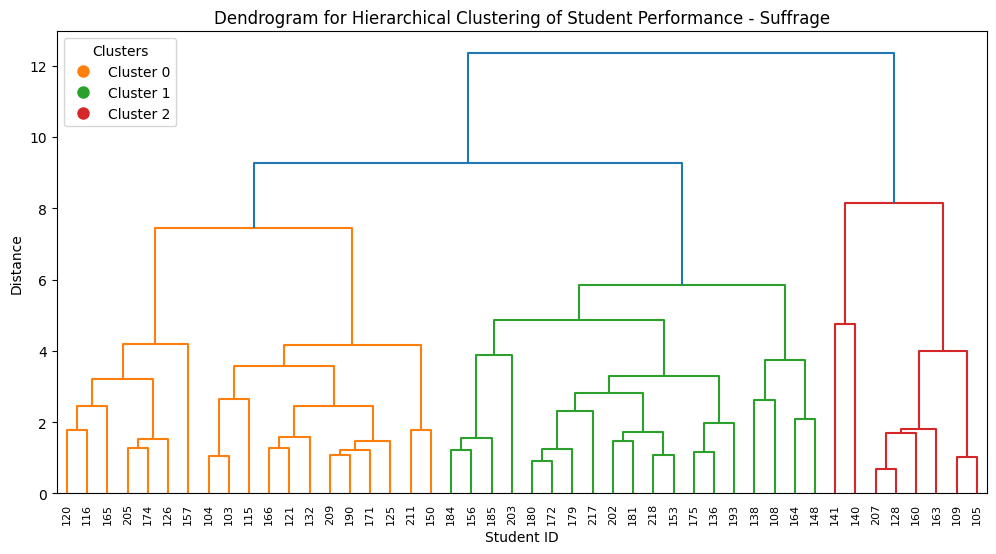

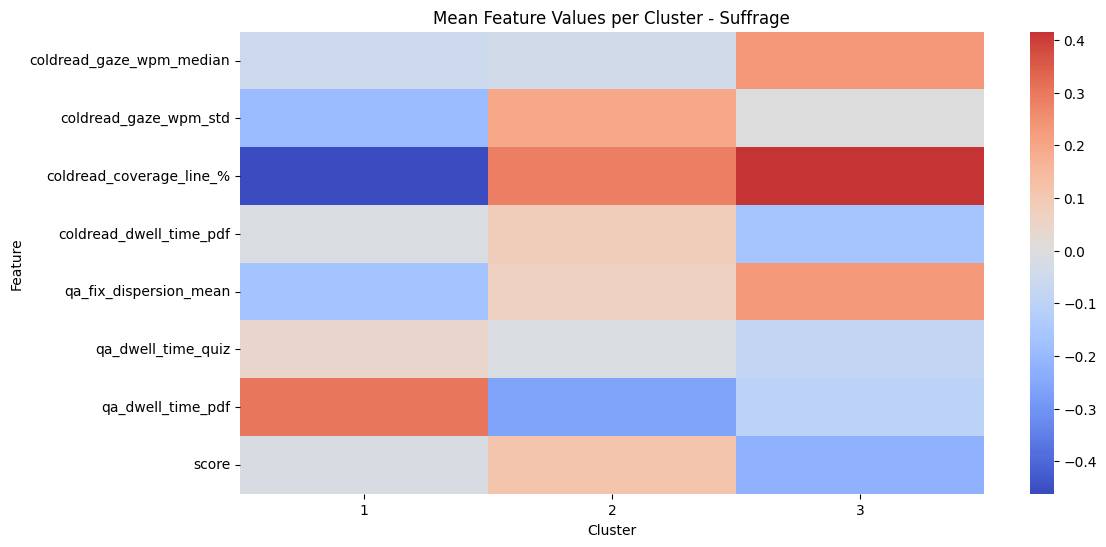

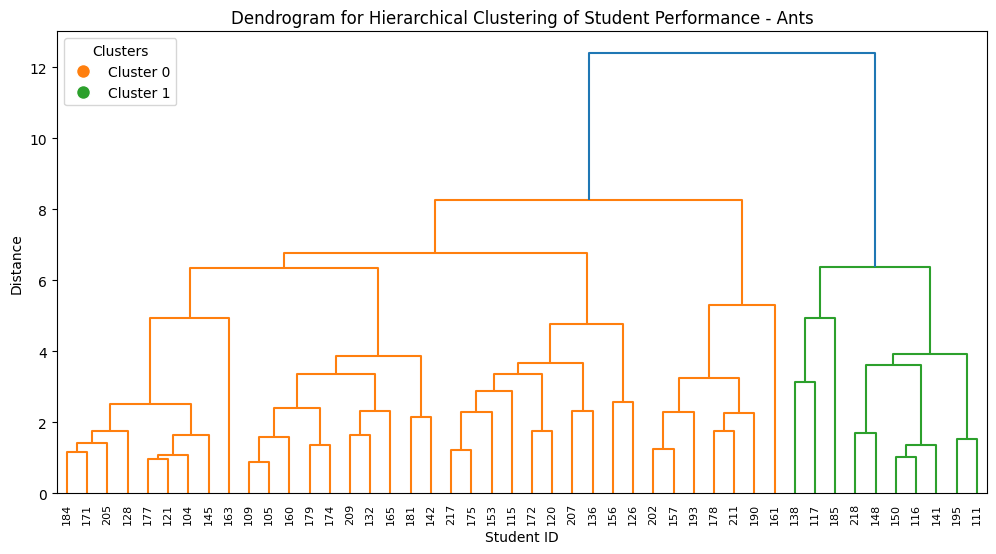

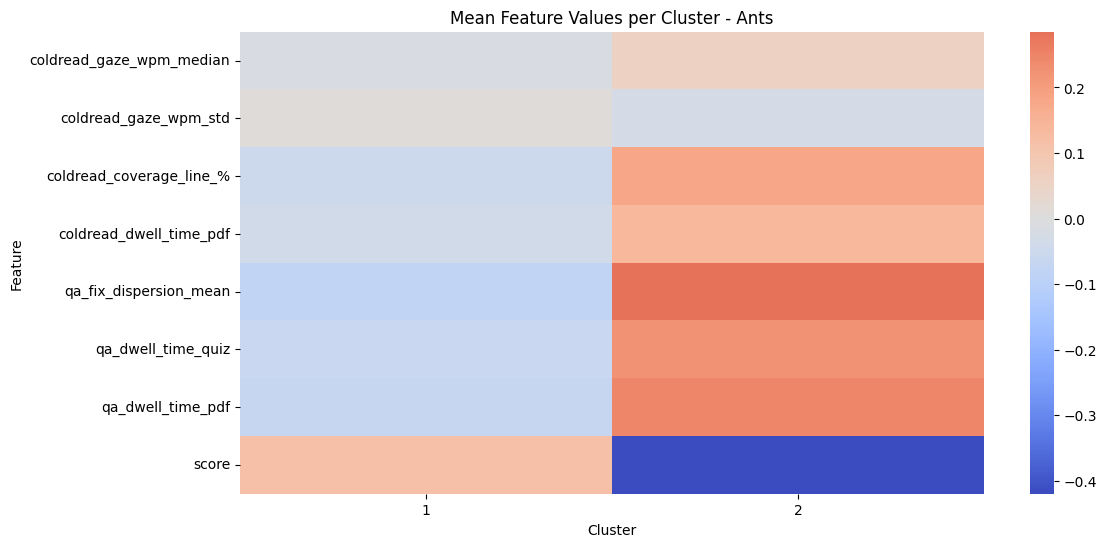

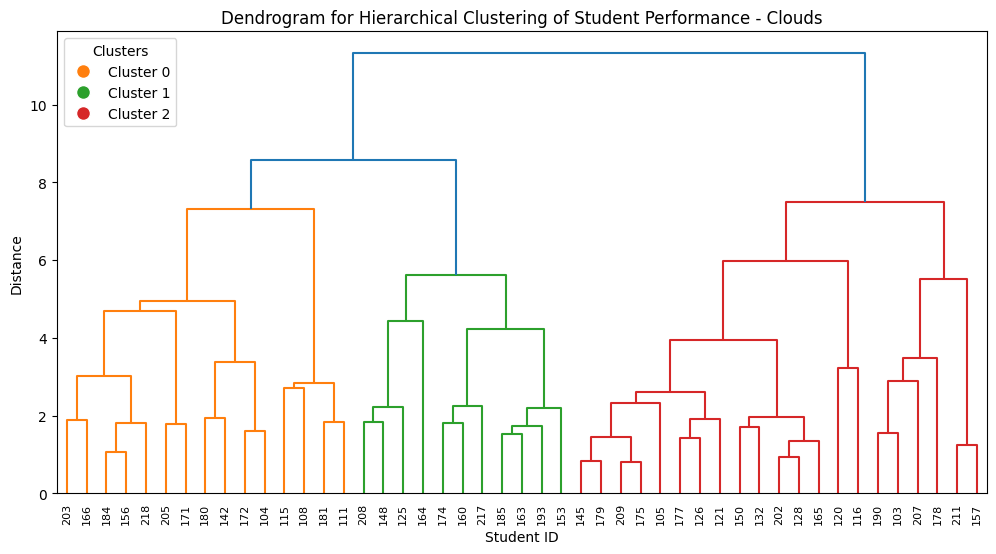

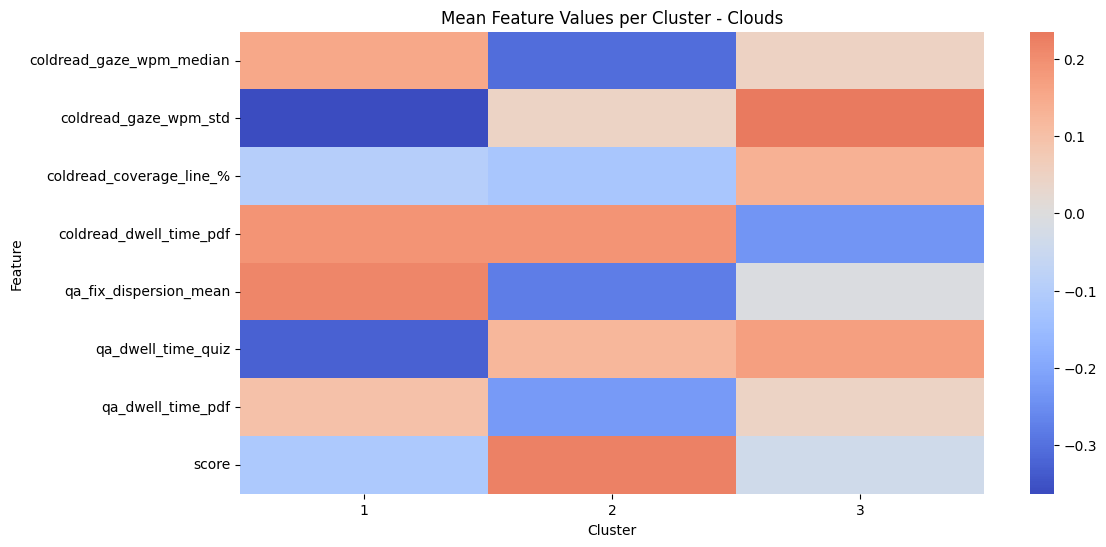

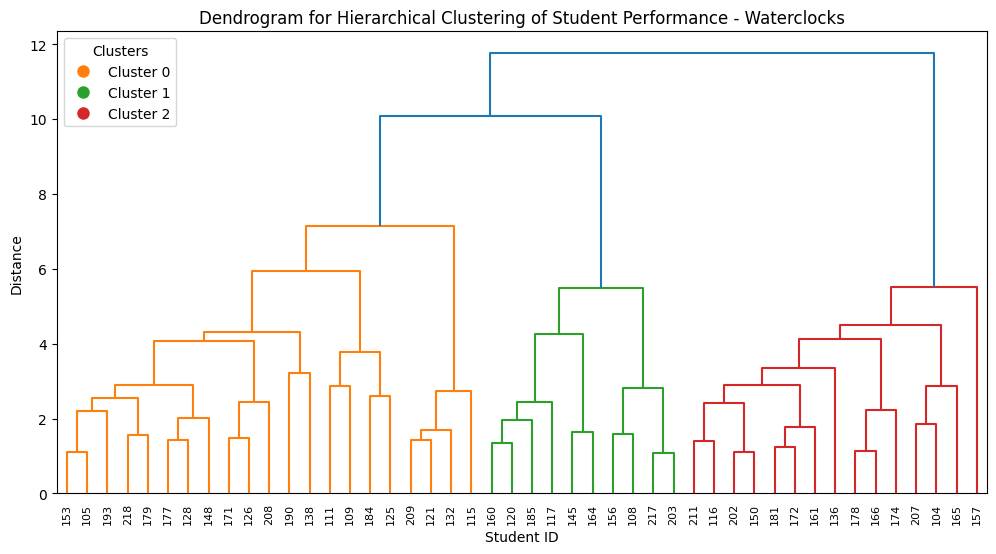

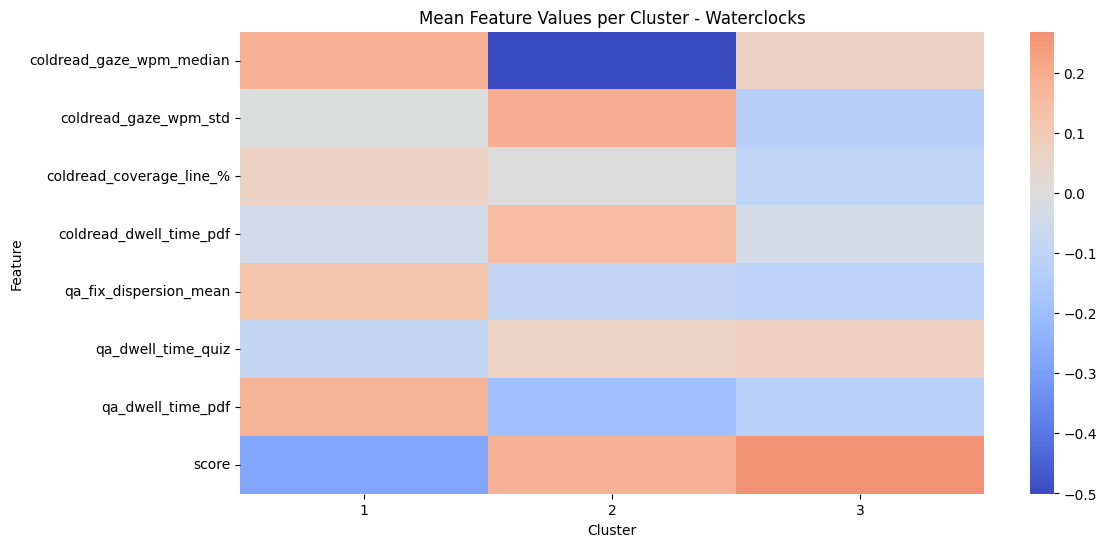

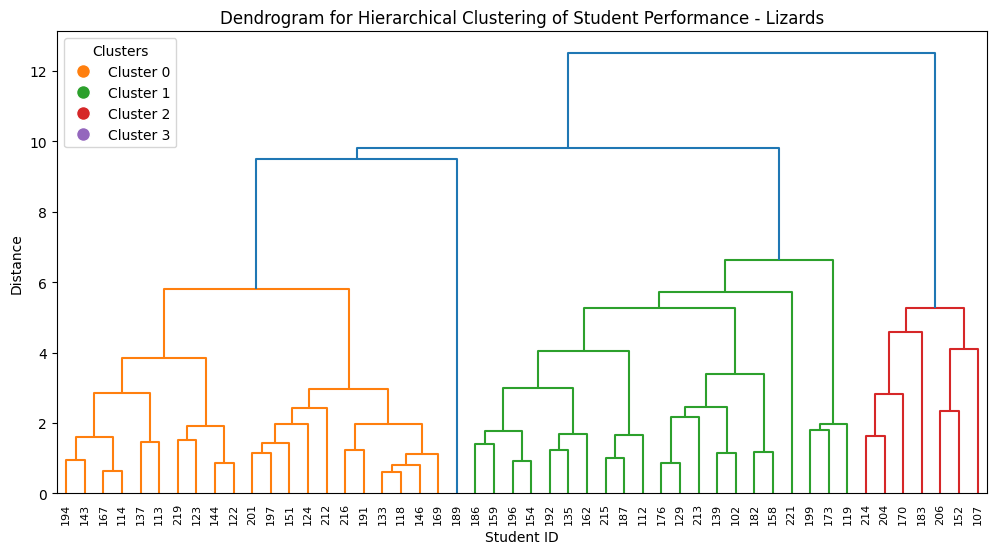

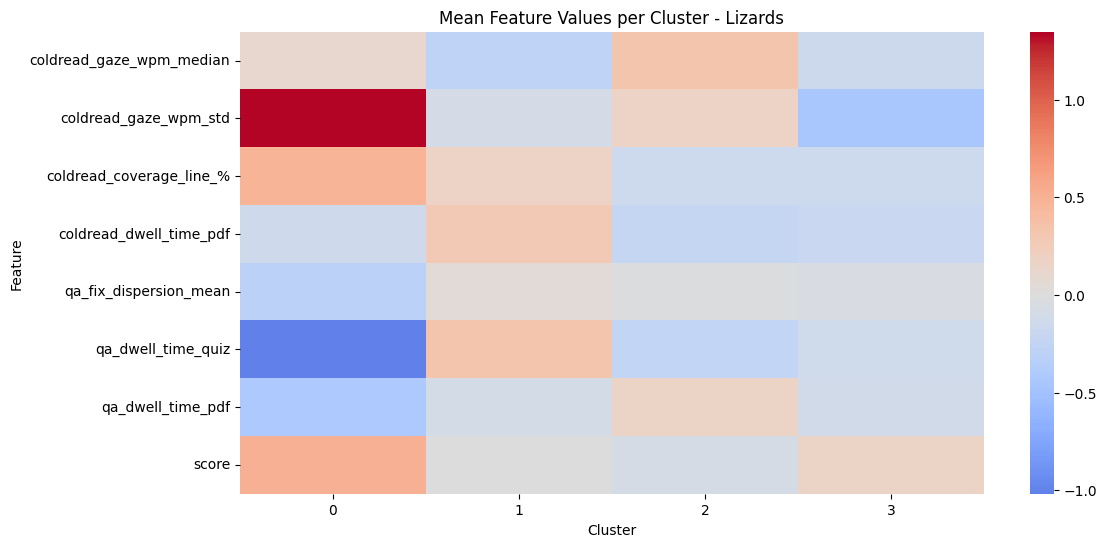

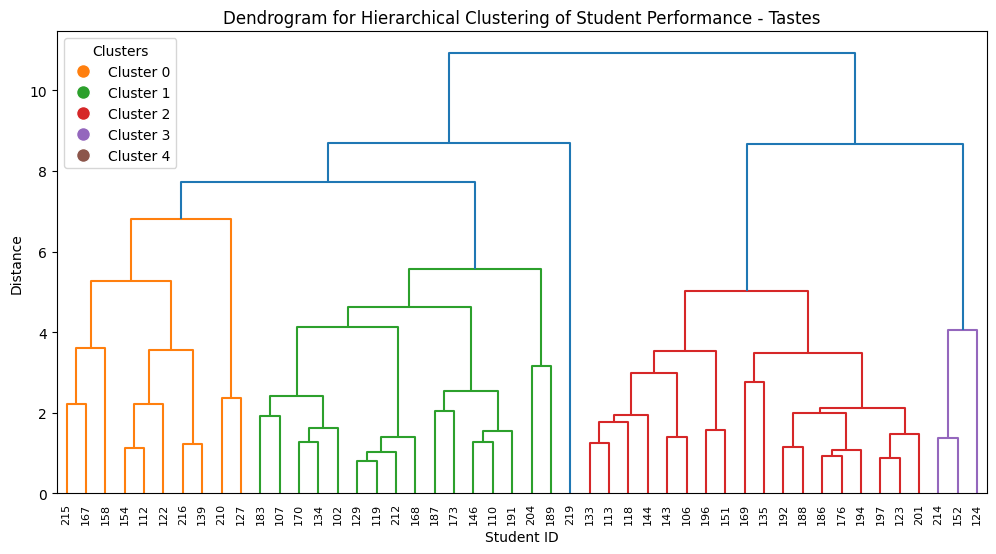

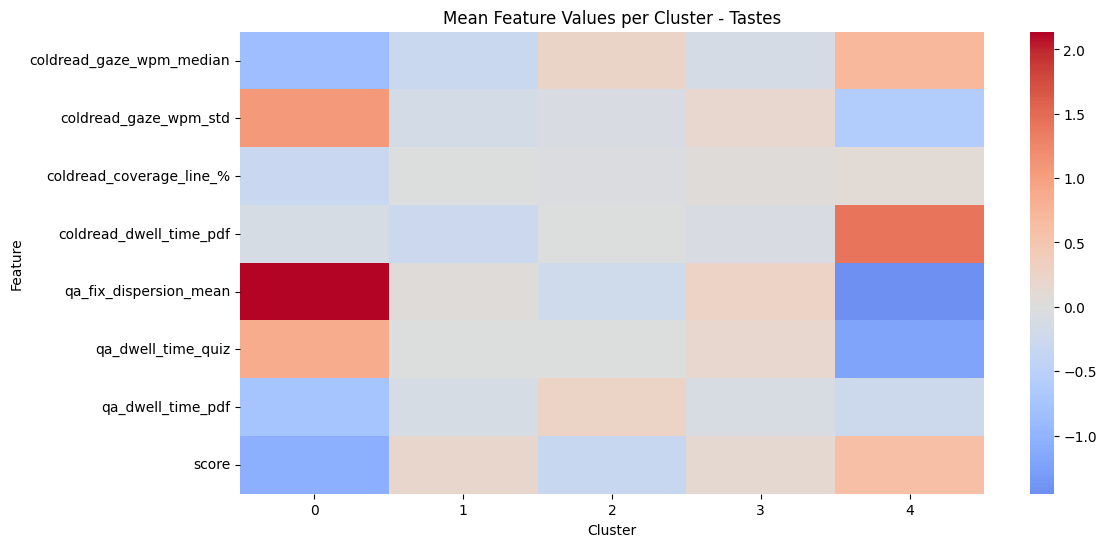

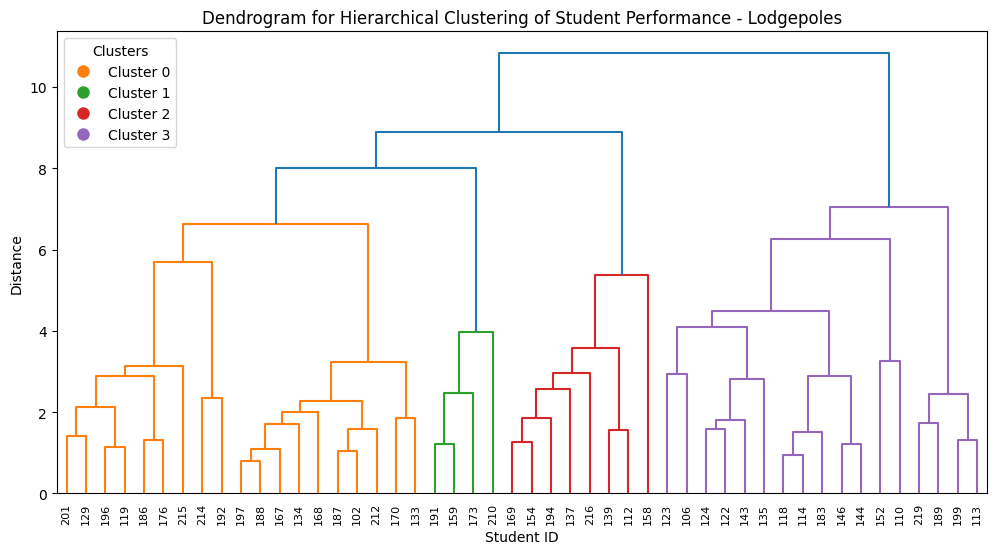

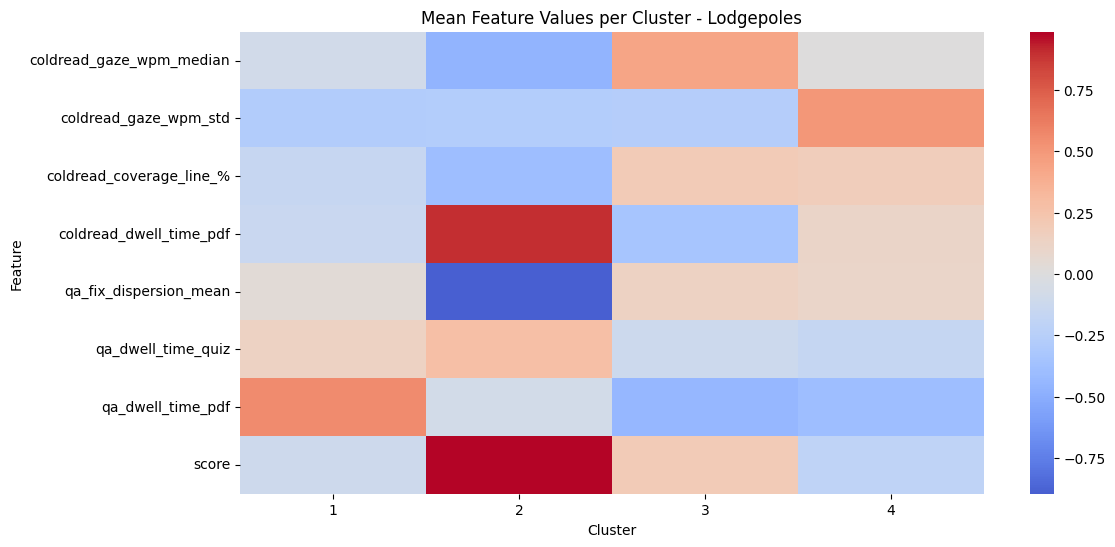

In [23]:
from sklearn.preprocessing import StandardScaler
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

cluster_plots_dir = CWD / 'data' / 'output' / 'cluster_dendrogram'
os.makedirs(cluster_plots_dir, exist_ok=True)
cluster_mean_heatmaps_dir = CWD / 'data' / 'output' / 'cluster_mean_heatmaps'
os.makedirs(cluster_mean_heatmaps_dir, exist_ok=True)
for assignment_name, df in zip(assignment_names, all_dfs):
    # Perform unsupervised clustering to identify groups of student
    # X = df[[f"{assignment_name}_{x}" for x in top_features] + [f"{assignment_name}_score", "valor_MAP", 'ELL']]
    X = df[top_features]

    # Select features for clustering (excluding student ID)
    features_for_clustering = X.copy()  # Use all relevant features

    # Normalize data (Hierarchical Clustering is distance-based, so we need to standardize)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(features_for_clustering)

    # # Only make the behavior data available
    # X_scaled = X_scaled[:, :-2]

    # Compute hierarchical clustering linkage matrix
    Z = hierarchy.linkage(X_scaled, method="ward")  # Ward's method minimizes variance within clusters
    # print(Z)

    # Plot the dendrogram to visualize the hierarchy
    plt.figure(figsize=(12, 6))
    dn = hierarchy.dendrogram(Z, labels=df['id'].values, orientation="top", distance_sort="descending")

    # Extract unique colors used in the dendrogram
    clusters = set(dn['leaves_color_list'])
    cluster_colors = np.array([[255,127,14,255],[44,160,44,255],[214,39,40,255],[148,103,189,255],[140,86,75,255]])/255

    # Create a legend mapping colors to cluster IDs
    legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=f'Cluster {i}', 
                                markerfacecolor=cluster_colors[i], markersize=10) for i in range(len(clusters))]

    plt.legend(handles=legend_handles, title="Clusters", loc="upper left")
    plt.title(f"Dendrogram for Hierarchical Clustering of Student Performance - {assignment_name}")
    plt.xlabel("Student ID")
    plt.ylabel("Distance")
    plt.savefig(str(cluster_plots_dir / f'{assignment_name}.png'))
    plt.show()

    # # Assign clusters to each student
    # # Convert the scaled data back to a DataFrame
    X_scaled_df = pd.DataFrame(X_scaled, columns=features_for_clustering.columns)

    # Obtain the clusters from the dendrogram without computing again
    leaves_color_list = dn['leaves_color_list']
    # Convert from "C1", "C2", "C3" to 1, 2, 3 and assign as the Cluster column
    X_scaled_df["Cluster"] = [int(x[1]) for x in leaves_color_list]
    

    # Add back the performance metrics (score and MAP)
    X_scaled_df[f"score"] = df[f"score"]

    # Normalize the performance metrics for visualization
    X_scaled_df[f"score"] = scaler.fit_transform(X_scaled_df[[f"score"]])

    # Print out the size of the clusters
    cluster_sizes = X_scaled_df['Cluster'].value_counts().sort_index()

    # Compute mean feature values per cluster
    cluster_summary = X_scaled_df.groupby("Cluster").mean()

    # Prinout the score and MAP mean per cluster in a non-normalized way
    score_map_summary = X_scaled_df.groupby("Cluster")[["score"]].mean()
    # print(score_map_summary)

    # Prinout the size of the clusters
    # print(cluster_sizes)

    # Plot the mean feature values per cluster
    plt.figure(figsize=(12, 6))
    sns.heatmap(cluster_summary.T, cmap="coolwarm", center=0)
    plt.title(f"Mean Feature Values per Cluster - {assignment_name}")
    plt.xlabel("Cluster")
    plt.ylabel("Feature")
    plt.savefig(str(cluster_mean_heatmaps_dir / f'{assignment_name}.png'))
    plt.show()

    # Assign the cluster to the original dataframe
    df['cluster'] = X_scaled_df['Cluster']
    # break

In [36]:
# Load the txts data for each passage
TXT_DIR = "./data/pdfs/txt"
texts = {}
for assignment_name in assignment_names:
    txt = open(f"{TXT_DIR}/{assignment_name}.txt", "r").read()
    texts[assignment_name] = txt

# Load the summaries of the passages
SUMMARY_DIR = "./data/pdfs/summaries"
summaries = {}
for assignment_name in assignment_names:
    txt = open(f"{SUMMARY_DIR}/{assignment_name}.txt", "r").read()
    summaries[assignment_name] = txt

# Load the questions for each passage
questions = pd.read_excel('./data/questions.xlsx', sheet_name=None)

# Load the feature descriptions (CSV)
feature_descriptions = pd.read_excel('feature_descriptions.xlsx')

# Core Reading Standards
with open('core_reading_standards.txt', 'r') as f:
    core_reading_standards = f.read()

In [ ]:
MODEL = 'llama3'
SEED = 1
# API = 'ollama'
API = 'openai'
API = "DEBUG"

# Define a JSON schema for the response
class ItemResponse(BaseModel):
    score: int
    justification: str

class Evaluation(BaseModel):
    Clarity: ItemResponse
    Relevance: ItemResponse
    Coherence: ItemResponse
    Actionability: ItemResponse

# Define the prompt for the clasroom-wide report of an assignment
def compute_group_metrics(df, assignment_name):
    #   print(df)

    # Compute the most missed questions
    missed_questions = df[[f"{j+1}" for j in range(num_of_questions[i])]].mean()
    missed_questions = missed_questions.sort_values(ascending=False)

    metrics = {
        'count': len(df),
        'students': df['id'].values.tolist(),
        # "duration_median": round(df['total_duration'].median(), 0),
        'score_mean_%': round(df[f"score"].mean() * 100, 0),
        **{f"{feature}": round(df[f"{feature}"].mean(),2) for feature in top_features},
        'most_missed_questions_(low_means_less_correct)': {k:round(v,2) for k, v in missed_questions.items() if v < 0.5}
    }

    # Round metrics to 2 decimal places
    metrics = {k: round(v, 2) if type(v) == float else v for k, v in metrics.items()}
    return metrics

def generate_prompt(assignment_name, df, text, summary):

    # Analyze the readability of text
    r = Readability(text)
    
    # Add information to the prompt
    ## Add ELL back
    ## Request definitions or explanations of used features and statistics

    # Compute the cluster's metrics
    cluster_metrics = {}
    for name, group in df.groupby('cluster'):
        cluster_metrics[name] = compute_group_metrics(group, assignment_name)

    # Compute the score distribution into bins
    score_distribution = df['score'].value_counts().sort_index().to_dict()

    # Obtain a list of learning outcomes per student ID
    learning_outcomes = {int(k):round(v,2) for k, v in df[['id', 'score']].values}

    # Get the questions for the assignment
    q_df = questions[assignment_name]

    prompt = {
      "role": "AI Educational Analyst",
      "task": "Generate a classroom-wide report for the reading assignment based on the provided student performance data. The report should analyze trends, justify key findings, and offer actionable recommendations. Be critical, don't simply praise the students, and provide helpful insights for a teacher. Also, do not simply write out the statistics, but provide a detailed analysis and evaluation of the data.",
      "chain-of-thought": "In prelude <think></think> tags, describe your thought process as you analyze the data and generate the report. Explain how you interpret the data, what insights you gain from it, and how you use these insights to generate the report.",
      "context": {
        "assignment": {
          "title": assignment_name,
          "flesch_kincaid_grade_level": r.flesch_kincaid().grade_level,
          "flesch_kincaid_score": round(r.flesch_kincaid().score,2),
          "word_count": len(text.split()),
          "summary": summary
        },
        "targets": {
            "reading_speed": "Average reading speed for 5th grader is 120-200 words per minute.",
            "multiple_choice": "Passing score for multiple choice questions is 70%, anything below is considered failing.",
            "text_coverage": "A higher text coverage indicates better understanding of the text.",
            "reading_standards": core_reading_standards
        },
        "constraints": {
            "bias_considerations": "Ensure all student cluster descriptions are framed positively and suggest learning strategies rather than labeling deficiencies."
        },
        'feature_descriptions': feature_descriptions.to_dict(),
        'questions': q_df.to_dict(),
        'learning_outcome_distribution': score_distribution,
        'assignment_scores': learning_outcomes,
        'cluster_metrics': cluster_metrics,
        "most_missed_questions_entire_class_(low_means_less_correct)": compute_group_metrics(df, assignment_name)['most_missed_questions_(low_means_less_correct)']
      },
      "output": {
        "title": f"Classroom-Wide Report: {assignment_name}",
        "items": {
            "Status": "Provide multiple status tags at the beginning of the report describing the performance of the classroom in the assignment (e.g., EXCELLENT, STRUGGLE READING, LOW ENGAGEMENT, POOR TEXT COMPREHENSION).",
            "Summary": "Provide a detailed summary of the classroom performance in the assignment, highlighting key insights and trends by referring to data. Provide concrete examples to support your analysis, such as referring to metrics. Connect to the broader curricular goals and reading standards",
            "Content": "Specify which content, based on the questions, did the students struggle with the most. Provide a detailed analysis of the most missed questions and how this relates to the students' performance.",
            "Clusters": "For the clusters, use the cluster's attributes and define names for each cluster (e.g, Careful Readers) and how this relates to their performance. Provide suggestions in how to support these clusters if they are struggling.",
            "Outliers": "Identify any outliers by providing their student ID in the classroom performance and provide an analysis of their performance. Provide suggestions on how to support these students.",
            "Recommendations": "Provide actionable recommendations for the teacher to improve the classroom performance in the assignment. These recommendations should be based on the analysis of the data and should be specific and practical. Suggest specific implementation details and measurable outcomes. Make concrete and step-by-step recommendations.",
        },
        "special_instructions": {
            "langugage": "Avoid dense language and use simple, clear, and concise language. A clearer simplification of tems and direct statements would help.",
            "description": "We have generated cluster denograms, mean cluster heatmaps, and score distribution plots for you to use in your analysis. Use the following tokens to place these plots within your response: <CLUSTER_DENDROGRAM>, <CLUSTER_HEATMAP>, <SCORE_DISTRIBUTION>.",
        },
        "format": "Markdown"
      }
    }
    return prompt

prompt_res_table = defaultdict(list)
timestamp = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
report_dir = CWD / 'data' / 'reports' / timestamp
os.makedirs(report_dir, exist_ok=True)
for assignment_name, df in zip(assignment_names, all_dfs):
    text = texts[assignment_name]
    summary = summaries[assignment_name]
    prompt = generate_prompt(assignment_name, df, text, summary)
    
    # Save input prompt
    with open(report_dir / f"{assignment_name}_prompt.json", "w") as f:
        f.write(json.dumps(prompt, indent=4))

    # Generate the report using Ollama
    if API == 'openai':
        res = openai_client.chat.completions.create(
            model='gpt-4o-mini',
            messages=[
                {
                    "role": "user",
                    "content": json.dumps(prompt)
                }
            ]
        )
        content = res.choices[0].message.content
    elif API == 'ollama':
        res = ollama.chat(
            model=MODEL,
            messages=[
                {
                    "role": "user",
                    "content": json.dumps(prompt)
                }
            ],
            options={
                "seed": SEED,
                "temperature": 0
            }
        )
        content = res['message']['content']
    else:
        content = "DEBUG"

    # Evaluate the response with Ollama
    eval_prompt = {
        "role": "Educator",
        "task": "Evaluate the generated classroom-wide report using a 1-5 Likert scale (5 = Excellent, 1 = Poor). Be brutally honest and nitpick aspects of the report that could be better. Provide a rating and a justification for each of the following criteria: clarity, relevance, coherence, and actionability. Respond only with valid JSON. Do not write a summary or introduction.",
        "evaluation_criteria": {
            "Clarity": "Does the report clearly communicate key insights in an understandable manner?",
            "Relevance": "Does the report accurately reflect student performance and provide useful insights based on the assignment data?",
            "Coherence": "Is the report well-structured and logically organized, making it easy to follow?",
            "Actionability": "Does the report provide meaningful, specific, and practical recommendations that teachers can apply in the classroom?"
        },
        "report": content,
        "raw_data": df.to_dict()
    }

    # Save evaluation prompt
    with open(report_dir / f"{assignment_name}_eval_prompt.json", "w") as f:
        f.write(json.dumps(eval_prompt, indent=4))

    if API == 'openai':
        res = openai_client.chat.completions.create(
            model='gpt-4o-mini',
            messages=[
                {
                    "role": "user",
                    "content": json.dumps(eval_prompt)
                }
            ]
        )
        eval_content = res.choices[0].message.content
    elif API == 'ollama':
        eval_res = ollama.chat(
            model=MODEL,
            format=Evaluation.model_json_schema(),
            messages=[
                {
                    "role": "user",
                    "content": json.dumps(eval_prompt)
                }
            ],
            options={
                "seed": SEED,
                "temperature": 0
            }
        )
        eval_content = Evaluation.model_validate_json(eval_res['message']['content'])
    else:
        eval_content = "DEBUG"
    

    # Write into a markdown file
    with open(report_dir / f"{assignment_name}.md", "w") as f:
        f.write(content)

    # Save eval into .txt
    with open(report_dir / f"{assignment_name}_eval.txt", "w") as f:
        f.write(eval_content)

    # Store the results in a table
    prompt_res_table['assignment'].append(assignment_name)
    prompt_res_table['prompt'].append(prompt)
    prompt_res_table['response'].append(content)
    prompt_res_table['evaluation'].append(eval_content)
    # prompt_res_table['clarity'].append(eval.Clarity.score)
    # prompt_res_table['relevance'].append(eval.Relevance.score)
    # prompt_res_table['coherence'].append(eval.Coherence.score)
    # prompt_res_table['actionability'].append(eval.Actionability.score)
    # prompt_res_table['clarity_justification'].append(eval.Clarity.justification)
    # prompt_res_table['relevance_justification'].append(eval.Relevance.justification)
    # prompt_res_table['coherence_justification'].append(eval.Coherence.justification)
    # prompt_res_table['actionability_justification'].append(eval.Actionability.justification)

    break

# Save the results into a table
prompt_res_df = pd.DataFrame(prompt_res_table)
prompt_res_df.to_excel(report_dir / "complete_table.xlsx", index=False)